# Low-shot visual anomaly detection (v2.1)

*This is the updated version of the homework with some additional clarifications and changes in the task descriptions (see slack channel for details). The code remains untouched.*

In this notebook you'll investigate visual anomaly detection in a typical industrial setting - we don't have much data and we can train only only normal (non-anomalous) examples.
Read the [PADIM paper](https://arxiv.org/pdf/2011.08785.pdf) carefully.
The code here is based on the original implementation from its authors.

If you have any questions - please write them on slack in the channel.

### Bibliography

1. Defard, T., Setkov, A., Loesch, A., & Audigier, R. (2021). [Padim: a patch distribution modeling framework for anomaly detection and localization](https://arxiv.org/pdf/2011.08785.pdf). In International Conference on Pattern Recognition (pp. 475-489). Cham: Springer International Publishing.

## Data

In case of any problems - please visit [MVTec AD](https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads) to get the access to the data.

In [45]:
%pip install --quiet gdown  # for those who don't run it on Google Colab
!wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz
!wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz
!wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz

In [46]:
from pathlib import Path
import tarfile

DATA_PATH = Path('./mvtec_anomaly_detection')
DATA_PATH.mkdir(exist_ok=True)

for class_name in ['bottle', 'metal_nut', 'transistor']:
    if not (DATA_PATH / class_name).exists():
        with tarfile.open(class_name + '.tar.xz') as tar:
            tar.extractall(path=DATA_PATH)

## PADIM implementation

In [47]:
import os
import random
import time
from pathlib import Path
from random import sample
from typing import cast, Any, Dict, List, Optional, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends, torch.backends.mps
import torch.nn.functional as F
from numpy.typing import NDArray
from matplotlib import colors
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
from torch.utils.data import DataLoader, Dataset
from torchvision.models import wide_resnet50_2, resnet18, Wide_ResNet50_2_Weights, ResNet18_Weights
from torch import nn
from torchvision import transforms as T
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

FloatNDArray = NDArray[np.float32]

In [48]:
# Leave it as is if you're unsure, this notebook will guess this for you below.
DEVICE: Optional[torch.device] = None
SEED: int = 42  # do not modify

plt.style.use("dark_background")

In [49]:
def seed_all(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_best_device_for_pytorch() -> torch.device:
    if torch.cuda.is_available():
        device_str = "cuda"     # GPU
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device_str = "mps"      # Apple silicon
    else:
        device_str = "cpu"      # CPU
    return torch.device(device_str)

In [50]:
if not DEVICE:
    DEVICE = get_best_device_for_pytorch()
print(f"Using PyTorch with {DEVICE} backend.")

seed_all(SEED)
print(f"Seeded everything with {SEED}.")

Using PyTorch with cpu backend.
Seeded everything with 42.


### MVTecDataset

In [51]:
class MVTecDataset(Dataset[Tuple[torch.Tensor, int, torch.Tensor]]):
    """MVTec dataset of industrial objects with and without anomalies.

    Yields (x, y, mask) tuples where:
    - x is an RGB image from the class, as float tensor of shape (3, cropsize, cropsize);
    - y is an int, 0 for good images, 1 for anomalous images;
    - mask is 0 for normal pixels, 1 for anomalous pixels, as float tensor of shape (1, cropsize, cropsize).

    Source: https://github.com/xiahaifeng1995/PaDiM-Anomaly-Detection-Localization-master/blob/main/datasets/mvtec.py
    """

    def __init__(self, dataset_path: Path, class_name: str = 'bottle',
                 is_train: bool = True, resize: int = 256, cropsize: int = 224, return_only_indices=False):
        self.dataset_path = dataset_path
        self.class_name = class_name
        assert (dataset_path / class_name).is_dir(), f'Dataset class not found: {dataset_path / class_name}'
        self.is_train = is_train

        self.resize = resize
        self.cropsize = cropsize

        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()

        # set transforms
        self.transform_x = T.Compose([T.Resize(resize, Image.LANCZOS),
                                      T.CenterCrop(cropsize),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, Image.NEAREST),
                                         T.CenterCrop(cropsize),
                                         T.ToTensor()])

        self.return_only_indices = return_only_indices

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, torch.Tensor]:
        if self.return_only_indices:  # Used for checking the answer of T1.1.
            return idx

        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]

        x = Image.open(x).convert('RGB')
        x = cast(torch.Tensor, self.transform_x(x))

        if y == 0:
            mask = torch.zeros([1, self.cropsize, self.cropsize])
        else:
            assert mask is not None
            mask = Image.open(mask)
            mask = cast(torch.Tensor, self.transform_mask(mask))

        return x, y, mask

    def __len__(self) -> int:
        return len(self.x)

    def load_dataset_folder(self) -> Tuple[List[Path], List[int], List[Optional[Path]]]:
        phase = 'train' if self.is_train else 'test'
        x: List[Path] = []
        y: List[int] = []
        mask: List[Optional[Path]] = []

        img_dir = self.dataset_path / self.class_name / phase
        gt_dir = self.dataset_path / self.class_name / 'ground_truth'

        for img_type_dir in sorted(img_dir.iterdir()):
            # Load images.
            if not img_type_dir.is_dir():
                continue
            img_fpath_list = sorted(img_type_dir.glob('*.png'))
            x.extend(img_fpath_list)

            # Load ground-truth labels and masks.
            if img_type_dir.name == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                mask.extend([gt_dir / img_type_dir.name / (f.stem + '_mask.png')
                            for f in img_fpath_list])

        assert len(x) == len(y) == len(mask), 'Number of x, y, and mask should be the same.'
        return x, y, mask

In [52]:
def sample_idx(number_of_features: int, max_number_of_features: int) -> torch.Tensor:
    assert number_of_features <= max_number_of_features
    return torch.tensor(sample(range(0, max_number_of_features), number_of_features))


def denormalization(x: FloatNDArray) -> NDArray[np.uint8]:
    """Denormalize with ImageNet values."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)


def embedding_concat(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Concatenate embeddings (along the channel dimension, upscaling y to match x).

    Args:
        x: Tensor of shape (B, C1, H1, W1).
        y: Tensor of shape (B, C2, H2, W2).

    Returns:
        Tensor of shape is (B, C1 + C2, H1, W1).
    """
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, s * s, H2, W2)
    z = torch.zeros(B, C1 + C2, s * s, H2, W2).to(x.device)
    for i in range(s * s):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), dim=1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

def concatenate_embeddings_from_all_layers(layer_outputs: Dict[str, torch.Tensor]) -> torch.Tensor:
        embedding_vectors = layer_outputs['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = embedding_concat(embedding_vectors, layer_outputs[layer_name])
        return embedding_vectors

def plot_fig(test_img, scores, gts, threshold: float, save_dir: Path, class_name: str):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in range(num):
        img = test_img[i]
        img = denormalization(img)
        gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i] * 255
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[2].imshow(img, cmap='gray', interpolation='none')
        ax_img[2].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask, cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img)
        ax_img[4].title.set_text('Segmentation result')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)

        fig_img.savefig(save_dir / f'{class_name}_{i}', dpi=100)
        plt.close()

In [53]:
def get_feature_extractor(arch: str) -> nn.Module:
    if arch == 'resnet18':
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=True)
        # t_d = 448
        # d = 40
    elif arch == 'wide_resnet50_2':
        model = wide_resnet50_2(weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1, progress=True)
        # t_d = 1792
        # d = 550
    else:
        raise NotImplementedError
    return model

### PADIM class

In [54]:
class PADIM():

    def __init__(
            self,
            backbone: str,
            device: torch.device,
            save_path: Path,
            backbone_features_idx: torch.Tensor,
            class_names: List[str] = ["bottle"],
            plot_metrics: bool = False,
    ) -> None:
        self.arch = backbone
        self.device = device
        self.model = get_feature_extractor(backbone)
        self.model.to(device)
        self.model.eval()

        self.feature_subset_indices = backbone_features_idx
        self.feature_subset_indices.to(device)

        self.outputs: Dict[str, torch.Tensor] = {}

        self.class_names = class_names
        self.save_path = save_path
        self.plot_metrics = plot_metrics

        self.setup_hooks()
        (self.save_path / f'temp_{self.arch}').mkdir(parents=True, exist_ok=True)

        self.mean: FloatNDArray  # shape (C, H * W)
        self.cov: FloatNDArray  # shape (C, C, H * W)

    def setup_hooks(self):
        """Setup hooks to store model's intermediate outputs."""
        self.model.layer1[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer1': x}))
        self.model.layer2[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer2': x}))
        self.model.layer3[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer3': x}))

    def train_and_test(self, train_dataloader: DataLoader, test_dataloader: DataLoader) -> float:
        self.train(train_dataloader)
        return self.test(test_dataloader)

    def train(self, train_dataloader: DataLoader) -> None:
        self.train_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        for x, _, _ in tqdm(train_dataloader, desc='Feature extraction (train)'):
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3'], list(self.outputs.keys())
            for k, v in self.outputs.items():
                self.train_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.train_outputs.items()})
        embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

        self.mean, self.cov = self.estimate_multivariate_gaussian(embedding_vectors_subset)
        del(self.train_outputs)

    def estimate_multivariate_gaussian(self, embedding_vectors: torch.Tensor
                                       ) -> Tuple[FloatNDArray, FloatNDArray]:
        """Calculates multivariate Gaussian distribution.

        Takes embeddings of shape (N, C, H, W).
        Returns (mean, covariance) of shape (C, H * W) and (C, C, H * W) respectively.
        """
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W)
        mean = torch.mean(embedding_vectors, dim=0).numpy()
        cov = torch.zeros(C, C, H * W).numpy()
        I = np.identity(C)
        for i in tqdm(range(H * W), desc="Covariance estimation"):
            cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
        return mean, cov

    def test(self, test_dataloader: DataLoader) -> float:
        self.test_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        test_imgs: List[FloatNDArray] = []
        gt_list: List[NDArray[Any]] = []
        gt_mask_list: List[FloatNDArray] = []

        # Extract test set features.
        for x, y, mask in tqdm(test_dataloader, desc='Feature extraction (test)', disable=False):
            x_shape = x.shape
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3']
            for k, v in self.outputs.items():
                self.test_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}
        gt_mask = np.asarray(gt_mask_list)  # shape (len(test_dataset), 1, H, W)

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.test_outputs.items()})
        # shape (len(test_dataset), len(feature_subset_indices), H1, W1)
        embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

        distances = self.calculate_distances(embedding_vectors_subset)
        score_map = self.prepare_anomaly_map((x_shape[2], x_shape[3]), distances)

        img_fpr, img_tpr, img_auroc = self.calculate_auroc_image_level(score_map, gt_list)
        pxl_fpr, pxl_tpr, pxl_auroc = self.calculate_auroc_pixel_level(score_map, gt_mask)

        if self.plot_metrics:
            print(f'[TEST] Image AUROC: {img_auroc:.3f}')
            print(f'[TEST] Pixel AUROC: {pxl_auroc:.3f}')
            threshold = self.calculate_optimal_threshold(score_map, gt_mask)
            self.plot_test_results_for_class(gt_mask_list, test_imgs, score_map, threshold, img_fpr, img_tpr, img_auroc, pxl_fpr, pxl_tpr, pxl_auroc)

        return pxl_auroc

    # TODO: Some of your code for Task 1 goes here. You can add more functions if needed, but use the ones below - we will use them for checking your solution.
    def test_permutation_importance(self, val_dataloader: DataLoader, features_to_permute: List[int]) -> List[float]:
        """Runs a series of tests on `val_dataloader`.
        Returns a list of pixelwise AUROCs, where the n-th element of the list is generated by testing the embeddings from `permute_feature(embeddings, n)."""
        results = []
        for i in features_to_permute:
          si = self.test_with_permuted_features(val_dataloader, i)
          results.append(si)
        return results

    def test_with_permuted_features(self, test_dataloader: DataLoader, feature_to_permute: int) -> float:
        self.test_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        test_imgs: List[FloatNDArray] = []
        gt_list: List[NDArray[Any]] = []
        gt_mask_list: List[FloatNDArray] = []

        # Extract test set features.
        for x, y, mask in tqdm(test_dataloader, desc='Feature extraction (test)', disable=False):
            x_shape = x.shape
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3']
            for k, v in self.outputs.items():
                self.test_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}
        gt_mask = np.asarray(gt_mask_list)  # shape (len(test_dataset), 1, H, W)

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.test_outputs.items()})
        # shape (len(test_dataset), len(feature_subset_indices), H1, W1)
        embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

        embedding_vectors_subset = self.permute_feature(embedding_vectors_subset, feature_to_permute) #To jedyna linijka którą zmieniłem

        distances = self.calculate_distances(embedding_vectors_subset)
        score_map = self.prepare_anomaly_map((x_shape[2], x_shape[3]), distances)

        #img_fpr, img_tpr, img_auroc = self.calculate_auroc_image_level(score_map, gt_list)
        pxl_fpr, pxl_tpr, pxl_auroc = self.calculate_auroc_pixel_level(score_map, gt_mask)

        #if self.plot_metrics:
        #    print(f'[TEST] Image AUROC: {img_auroc:.3f}')
        #    print(f'[TEST] Pixel AUROC: {pxl_auroc:.3f}')
        #    threshold = self.calculate_optimal_threshold(score_map, gt_mask)
        #    self.plot_test_results_for_class(gt_mask_list, test_imgs, score_map, threshold, img_fpr, img_tpr, img_auroc, pxl_fpr, pxl_tpr, pxl_auroc)

        return pxl_auroc
    def permute_feature(self, embedding_vectors_subset: torch.Tensor, number_of_feature_to_permute: int) -> torch.Tensor:
        """Permutes the embeddings.

        Takes embeddings of shape (N, C, H, W) and feature number to permute.
        Returns embeddings with the same shape. See the description of T1 for the details.
        """
        N, C, H, W = embedding_vectors_subset.size()
        output = embedding_vectors_subset.clone()

        for n in range(N):
                     # Get the values to shuffle
                values_to_shuffle = output[n, number_of_feature_to_permute, :, :]

                # Reshape the values to shuffle for easier manipulation
                reshaped_values = values_to_shuffle.view(-1, H * W)

                # Convert to numpy for shuffling (PyTorch doesn't have an in-place shuffle along a specific dimension)
                reshaped_values_np = reshaped_values.cpu().numpy()
                np.random.shuffle(reshaped_values_np[0])

                # Convert back to PyTorch tensor
                reshaped_values = torch.from_numpy(reshaped_values_np).to(output.device)

                # Reshape back to original shape and assign shuffled values
                output[n, number_of_feature_to_permute, :, :] = reshaped_values.view(H, W)

        return output
    # TODO: End of your code for Task 1 (here)

    def plot_test_results_for_class(self, gt_mask_list, test_imgs,
                                    score_map, threshold: float,
                                    img_fpr, img_tpr, img_auroc: float,
                                    pxl_fpr, pxl_tpr, pxl_auroc: float):
        _, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(img_fpr, img_tpr, label=f'Image AUROC: {img_auroc:.3f}')
        ax[1].plot(pxl_fpr, pxl_tpr, label=f'Pixel AUROC: {pxl_auroc:.3f}')

        save_dir = self.save_path / f'pictures_{self.arch}'
        save_dir.mkdir(parents=True, exist_ok=True)
        plot_fig(test_imgs, score_map, gt_mask_list,
                 threshold, save_dir, "")

    def calculate_auroc_image_level(self, score_map: FloatNDArray, gt_list: List[NDArray[Any]]) -> Tuple[FloatNDArray, FloatNDArray, float]:
        """Calculate image-level AUROC score."""
        img_scores = score_map.reshape(score_map.shape[0], -1).max(axis=1)
        fpr, tpr, _ = roc_curve(gt_list, img_scores)  # false-positive-rates and true-positive-rates for consecutive thresholds (for plotting).
        img_auroc = roc_auc_score(gt_list, img_scores)
        return fpr, tpr, float(img_auroc)

    def calculate_auroc_pixel_level(self, score_map: FloatNDArray, gt_mask: FloatNDArray) -> Tuple[FloatNDArray, FloatNDArray, float]:
        """Calculate per-pixel level AUROC."""
        assert score_map.shape == gt_mask.squeeze().shape, f"{score_map.shape=}, {gt_mask.shape=}"
        fpr, tpr, _ = roc_curve(gt_mask.flatten(), score_map.flatten())
        per_pixel_auroc = roc_auc_score(gt_mask.flatten(), score_map.flatten())
        return fpr, tpr, float(per_pixel_auroc)

    def calculate_optimal_threshold(self, score_map: FloatNDArray, gt_mask: FloatNDArray) -> float:
        """Calculate the optimal threshold with regard to F1 score."""
        assert score_map.shape == gt_mask.squeeze().shape
        precision, recall, thresholds = precision_recall_curve(
            gt_mask.flatten(), score_map.flatten())
        a = 2 * precision * recall
        b = precision + recall
        f1 = np.divide(a, b, out=np.zeros_like(a), where=(b != 0))
        threshold = thresholds[np.argmax(f1)]
        return threshold

    def calculate_distances(self, embedding_vectors: torch.Tensor) -> FloatNDArray:
        """Calculate Mahalanobis distance of each embedding vector from self.mean.

        For embeddings of shape (N, C, H, W), returns shape (N, H, W).
        """
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
        dist_list: List[List[np.float64]] = []
        for i in range(H * W):
            mean = self.mean[:, i]
            conv_inv = np.linalg.inv(self.cov[:, :, i])
            dist = [mahalanobis(sample[:, i], mean, conv_inv)
                    for sample in embedding_vectors]
            dist_list.append(dist)

        return np.array(dist_list).transpose(1, 0).reshape(B, H, W)

    def prepare_anomaly_map(self, shape: Tuple[int, int], distances: FloatNDArray) -> FloatNDArray:
        """Upsample distances to `shape`, apply Gaussian smoothing, and normalize to [0,1].

        For distances of shape (N, H, W) and `shape` equal to (H2, W2), returns shape (N, H2, W2).
        """
        dists = torch.Tensor(distances).unsqueeze(1)
        shape = (dists.shape[0],) + shape
        score_map = cast(FloatNDArray, F.interpolate(
            dists, size=shape[2], mode='bilinear', align_corners=False).squeeze().numpy())
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)

        min_score, max_score = score_map.min(), score_map.max()
        return (score_map - min_score) / (max_score - min_score + 1e-10)

### Let's see whether it works.
Take a look to the `SAVE_PATH` to inspect the results.

========== bottle


Feature extraction (test): 100%|██████████| 42/42 [00:12<00:00,  3.32it/s]


[TEST] Image AUROC: 0.998
[TEST] Pixel AUROC: 0.981


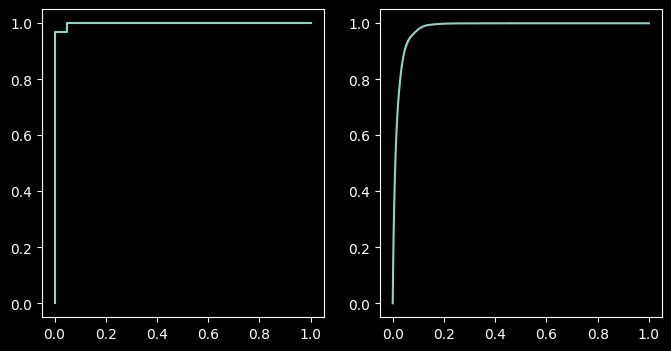

In [55]:
seed_all(SEED)
CLASS_NAMES = [
            'bottle', #'metal_nut'
            # 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
            # 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
        ]
BATCH_SIZE = 2
RESIZE = 256 * 1
CROP_SIZE = 224 * 1
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 50
MAX_NUMBER_OF_BACKBONE_FEATURES = 448

run_timestamp = time.time()
for class_name in CLASS_NAMES:
    print('=' * 10, class_name)
    SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

    train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

    padim = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=sample_idx(NUMBER_OF_BACKBONE_FEATURES, MAX_NUMBER_OF_BACKBONE_FEATURES),
        save_path=SAVE_PATH,
        plot_metrics=True,
    )

    padim.train_and_test(
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
    )

# Task 1. Finding the right features (40%)

The authors of the paper argue that it doesn't really matter how we choose a subset of features. Let's make some steps towards exploring whether it's true for three different classes (`bottle`, `transistor`, `metal_nut`).
Design an experiment which will rank the ResNet18 features by its importance. To do so, we'll implement our variation of [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm) on a subset of features produced by the backbone.

## 1.1 Preparing the data
- Using the test dataset, create `val_dataloader` (every even sample from the original test dataset) and `test_dataloader` (every odd sample). `SubsetRandomSampler` might be handy here.
- Then, create 3-fold cross validation-like process in which you'll train three PADIM models on the first 100 ResNet features in three equally sized subsets of train dataset in which you discard 1/3 of the data ($\texttt{padim}_{k}\texttt{.train}(\texttt{train\_dataloader}_k)$) (see below). Again, `SubsetRandomSampler` might be handy here.

In other words, you should have:

- for $k=0$, the first 10 images indexes from the train dataset we should train on are `[1, 2, 4, 5, 7, 8, 10, 11, 13, 14]`,
- for $k=1$, that's `[0, 2, 3, 5, 6, 8, 9, 11, 12, 14]`,
- and for $k=2$, that's `[0, 1, 3, 4, 6, 7, 9, 10, 12, 13]`.

For val and train, you should have `[0, 2, 4, ...]` and `[1, 3, 5, ...]` respectively (from the test dataset).

Don't worry about the sampling order.
Use these names for DataLoaders `val_dataloader`, `test_dataloader`. For k-fold training, store dataloaders in `train_dataloaders: List[DataLoader]`, where each element represent different $k$.
For each class, store the results in `dataloaders` dictionary (the variable is defined in the code below) - we will use this to check your solution.

## 1.2 Calculating the importances
- In a given fold, each $j$-th feature shall be ranked based on the pixel-wise AUROC difference between the output of that model ($s_{k} \leftarrow \texttt{padim}_{k}\texttt{.test}(\texttt{val\_dataloader})$) and the output with the model with permuted $j$-th feature ($s_{k, j} \leftarrow \texttt{padim}_{k}\texttt{.test\_permutation\_importance}(\texttt{val\_dataloader, features\_to\_permute=}[j])$). In practice you can pass all the numbers of features to permute (instead of 1-element list and do the loop inside the method. See also `test_permutation_importance` method stub above.
- Implement `permute_feature` method as follows: given the tensor with embeddings with shape `[B, C, H, W]`, by permutation of the $j$-th feature we mean randomly swapped values for $C=j$. Although (ideally) the order of swapping shall be **different** for every image, we don't require you to strictly guarantee that you won't get the same permutation twice (what matters here is not using the same permutation for **every** sample - you can e.g. use distinct calls to a shuffling function for every sample). In other words, for every image $b$ and feature $j$ you need to shuffle the last two dimensions (marked as stars in `[b, j, *, *]`) in an (ideally) unique manner.
- Then, calculate the mean importance $i$ averaged on these folds and plot weights importance for the class ($i_j \leftarrow \frac{1}{K} \sum_{k} ( s_k -  s_{k, j} )$, where $K$ is the number of folds).
- Append results in `results` dictionary, where keys are class names and values are the lists of averaged feature importances (from feature 0 to feature 99).

## 1.3 Drawing conclusions

- Finally, for every class train three models on the full training data and evaluate it on the `test_dataloader`. The first model shall use the first 10 features, the second shall use worst 10 features (in terms of feature importance), and the third shall contain the best 10 features.
- Write your conclusions (with the things enlisted below in mind). Simply plotting charts or outputting logs without any comment doesn't qualify as an answer to a question.

Note 1: Limit yourself to the first 100 features of ResNet18. If you want, you can go with all of available features instead of 100, but it'll take some time to calculate. Converting parts of the code to PyTorch and running on GPU might change a lot here, but this is not evaluated in this exercise. This experiment can be calculated without GPU in less than one hour anyway.

Note 2: If you'd like to be fully covered, one needs to explore if the features are correlated, as this might bias the results of feature importance calculations. However, this is not evaluated in this task for the sake of simplicity (that is, examining the 100 first features without worrying about correlated features are enough to get 100% from this task).

In [56]:
# do not modify
CLASS_NAMES = ['bottle', 'transistor', 'metal_nut']

BATCH_SIZE = 1
RESIZE = 256 * 2 // 4
CROP_SIZE = 224 * 2 // 4
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 10
MAX_NUMBER_OF_BACKBONE_FEATURES = 100  # 448
folds = 3

In [57]:
seed_all(SEED)
results = {c: [0] * MAX_NUMBER_OF_BACKBONE_FEATURES for c in CLASS_NAMES}

run_timestamp = time.time()
print(f"{run_timestamp}")

idx_all_fatures = torch.Tensor(range(MAX_NUMBER_OF_BACKBONE_FEATURES)).int()
idx_first_n_features = torch.Tensor(range(NUMBER_OF_BACKBONE_FEATURES)).int()

dataloaders = {c: {"val_dataloader": None, "test_dataloader": None, "train_dataloaders": None} for c in CLASS_NAMES}

# TODO: Your code for T1.1, T1.2, and T1.3 goes below. Don't forget to write `test_permutation_importance` and `permute_feature` above in the PADIM code.


# Data loaders for task 1.1

for class_name in CLASS_NAMES:
    print('CLASS NAME = ', class_name)
    #print('=' * 10, class_name)
    #SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

    #train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    #train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
    train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    val_indexes = []
    test_indexes = []
    for i in range(len(test_dataset)):
      if i%2 == 0:
        val_indexes.append(i)
      else:
        test_indexes.append(i)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indexes)
    val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = val_sampler)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indexes)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = test_sampler)
    dataloaders[class_name]["val_dataloader"] = val_dataloader
    dataloaders[class_name]["test_dataloader"] = test_dataloader

    fold_0_indexes = []
    fold_1_indexes = []
    fold_2_indexes = []

    for i in range(len(train_dataset)):
      if i%3 == 0:
        fold_1_indexes.append(i)
        fold_2_indexes.append(i)
      if i%3 == 1:
        fold_0_indexes.append(i)
        fold_2_indexes.append(i)
      if i%3 == 2:
        fold_0_indexes.append(i)
        fold_1_indexes.append(i)

    fold_0_sampler = torch.utils.data.SubsetRandomSampler(fold_0_indexes)
    fold_1_sampler = torch.utils.data.SubsetRandomSampler(fold_1_indexes)
    fold_2_sampler = torch.utils.data.SubsetRandomSampler(fold_2_indexes)
    fold_0_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = fold_0_sampler)
    fold_1_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = fold_1_sampler)
    fold_2_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = fold_2_sampler)
    train_dataloders = [fold_0_dataloader, fold_1_dataloader, fold_2_dataloader]
    dataloaders[class_name]["train_dataloaders"] = train_dataloders

1702947078.0633736
CLASS NAME =  bottle
CLASS NAME =  transistor
CLASS NAME =  metal_nut


In [ ]:
#Task 1.2

for class_name in CLASS_NAMES:
    print('CLASS NAME = ', class_name)

    test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
    train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    val_indexes = []
    test_indexes = []
    for i in range(len(test_dataset)):
      if i%2 == 0:
        val_indexes.append(i)
      else:
        test_indexes.append(i)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indexes)
    val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = val_sampler)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indexes)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = test_sampler)
    dataloaders[class_name]["val_dataloader"] = val_dataloader
    dataloaders[class_name]["test_dataloader"] = test_dataloader

    fold_0_indexes = []
    fold_1_indexes = []
    fold_2_indexes = []

    for i in range(len(train_dataset)):
      if i%3 == 0:
        fold_1_indexes.append(i)
        fold_2_indexes.append(i)
      if i%3 == 1:
        fold_0_indexes.append(i)
        fold_2_indexes.append(i)
      if i%3 == 2:
        fold_0_indexes.append(i)
        fold_1_indexes.append(i)

    fold_0_sampler = torch.utils.data.SubsetRandomSampler(fold_0_indexes)
    fold_1_sampler = torch.utils.data.SubsetRandomSampler(fold_1_indexes)
    fold_2_sampler = torch.utils.data.SubsetRandomSampler(fold_2_indexes)
    fold_0_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = fold_0_sampler)
    fold_1_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = fold_1_sampler)
    fold_2_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = fold_2_sampler)
    train_dataloders = [fold_0_dataloader, fold_1_dataloader, fold_2_dataloader]
    dataloaders[class_name]["train_dataloaders"] = train_dataloders
    #print(len(dataloaders[class_name]["train_dataloaders"]))

    #Task 1.2
    padim_0 = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=torch.tensor(range(MAX_NUMBER_OF_BACKBONE_FEATURES)),
        save_path=SAVE_PATH,
        plot_metrics=False,)
    padim_1 = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=torch.tensor(range(MAX_NUMBER_OF_BACKBONE_FEATURES)),
        save_path=SAVE_PATH,
        plot_metrics=False,)
    padim_2 = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=torch.tensor(range(MAX_NUMBER_OF_BACKBONE_FEATURES)),
        save_path=SAVE_PATH,
        plot_metrics=False,)

    lst = range(100)


    padim_0.train(train_dataloader = fold_0_dataloader)
    padim_1.train(train_dataloader = fold_1_dataloader)
    padim_2.train(train_dataloader = fold_2_dataloader)

    s0 = padim_0.test(val_dataloader)
    s1 = padim_1.test(val_dataloader)
    s2 = padim_2.test(val_dataloader)

    r0 = padim_0.test_permutation_importance(val_dataloader, lst)
    r1 = padim_1.test_permutation_importance(val_dataloader, lst)
    r2 = padim_2.test_permutation_importance(val_dataloader, lst)
    feature_importances_list = []
    for a, b, c in zip(r0, r1, r2):
      feature_importances_list.append((s0 - a + s1 - b + s2 - c)/3)
    results[class_name] = feature_importances_list
    print(feature_importances_list)

1702935925.839321
CLASS NAME =  bottle


Feature extraction (train):  54%|█████▍    | 75/139 [00:05<00:04, 13.22it/s]


KeyboardInterrupt: ignored

Colab has deleted the results of my calculations, so I paste them here from an earlier version.

In [58]:
results['bottle'] = [0.000191622558776805, 0.0004815440324949701, 1.3234159597937575e-05, 0.0010294835711466277, 0.00023940021607800807, 0.00022575076488233017, 0.00015909697770544184, 0.0002822931695400192, 0.00048811057323394635, 0.00015757410805750105, 0.0024502307533298406, 0.0012722739095760345, 0.0006876225100690414, 0.0008719354015675659, 0.0016322923989724087, 0.00026851125817728416, 0.0002587347094736477, 0.0005836075388024146, 0.0005603330306553911, 0.00036667268747581083, 0.00047928185767594683, 0.0019657749802876046, 0.0005539794663987166, 0.00040181190891393676, 0.00012524622635682695, 0.0014078818640706665, 0.0011978446077393807, 0.00042247264290447745, 0.000916686384605477, 0.0002768674285067811, 0.0006624875724933569, 0.0004519073891884699, 0.0002457895941655834, 0.00011163742214511292, 0.00024854739293659706, 3.660516356770079e-05, 0.0007050410513096775, 0.0003849108495180831, 0.0005871493201431802, 0.0005004665037787367, 0.0003007440906563537, 0.0007836391482885693, 0.0008386926742445974, 0.0015970467060168285, 0.005969254047638557, 0.00041432154710300634, 0.0008618898435818941, 0.00038109905547256684, 0.0005822431263331115, 0.0009850234301977585, 0.001095203272069652, 0.004422075103461043, 0.0003235167787157452, 0.00040435957423382945, 0.0002606802124292355, 0.00047339684168038837, 0.0005933002515338867, 0.0018115411579172624, 0.0006660939658984141, 0.00043702196363763307, 0.002471504269242364, 0.00040351991006241467, -0.00027653848980021173, 0.0004118452502273791, 0.00017998572279605737, 5.493532275402391e-05, 0.0001247448996187043, -2.473847687867181e-05, 0.0001131973264550205, 0.00034812623215022914, 0.00011210428967300956, 0.0005894388716799481, 0.0013829971801330905, -4.533487474611686e-05, 0.00016249480968844043, 0.00011851980692367814, 8.739506256808897e-05, 0.0002471229256146475, 0.0004837288016092585, 0.0002944336234075677, 0.0005073620835667203, 0.0003037991785076466, 0.00045908423673982995, 0.0003348888448756841, -3.6065439186216963e-06, 0.00013743452676658516, 0.00013912584601157482, 0.002534088926243294, 0.00020091088377131397, 0.0005827328551764414, 0.00017228834132236118, -1.769354597365898e-05, 0.0004616556413700919, 0.00031358106207572217, 0.0012235979213189863, 0.005985199957264431, 7.240946197772935e-05, 0.0007107785223491684, 8.859677839760198e-05, 2.38899407774736e-05]
results['transistor'] = [0.00038017849354099464, -3.796649252429951e-05, 0.002048790293904257, 0.0026002991445246426, 0.00209775681486161, 0.003532665953959772, -0.000680499738485644, 0.0032717312939810985, 0.003770979350275927, 0.0006715065339624552, 0.00048616395990945066, 0.0021747727376854784, 0.0024626300545394684, -0.0010413354228662557, 0.0018620833408266035, -0.00020971817409398685, 0.0011649514213318464, 0.0007703210516539771, 0.001471956111582462, -0.001178030054613699, 0.002583315628182703, 0.0006327128895342963, 0.0021147615180990473, 0.0008139327438449288, 0.0001149451974981434, 0.0002607266598079934, 5.881888809936934e-05, 0.00057537943171726, 0.00329494402818975, 0.002977347382130846, 0.0023612854982756706, -0.0003600450701811697, 0.0007676628751474383, 0.0005834432943154777, 0.0011913411001672387, 2.6603924637343585e-07, 0.0006896869526611393, 0.0006865170288903691, 0.0009372425964245812, 0.0009573738403938122, 0.003625676659147333, -0.0020359926557548627, 0.00015327952436653783, 0.00042087936811230353, -0.0005513898690523803, -0.0005995911679058293, 0.0026880522451738407, -0.0008970956308201883, 0.000804908384273606, 0.0008780359815558544, 0.0007140466826421518, 0.00016966790615317398, 0.0010758621786631413, 0.0006421667353411209, -0.0006964365695344421, -0.0008205258248842329, 0.0016636829766578283, 0.00019206590659677966, 0.0015565061149166077, -0.0002732839506558819, 0.0008396628571450219, -1.6092789124770118e-05, 0.00100187968246912, 0.0002256809091758146, 0.0006127887242484512, 0.004965099919549447, 0.0007198348298612286, 0.0028963885173570367, 0.00021583509483258378, 0.0013070425828046368, 0.0004624126748562866, -0.0006755577579887392, 0.0023774265704118447, 3.173733316463867e-05, 0.0010961211290765698, 2.5376598576635583e-05, -0.0004448269226559794, 0.0007789966063260397, 0.0010619438071304648, 0.00045776171615160194, 0.00036523178601466366, 0.00018250356662563583, 0.00018289377994810488, 0.0019915909417490183, -6.541865357904501e-06, 0.005478917597586008, 0.00040279806781003585, 0.007776431739861793, 0.0012315147669645181, 0.0022683847426173687, 0.0015042298527677689, 0.000707773489351804, -0.0006241096204249175, 7.500100298918344e-05, 0.0005398492566518106, -0.0004034999120623439, 0.0004725152111850391, -0.00011158116900082209, -0.0009168041022473705, 0.002495042538076938]
results['metal_nut'] = [0.002027749095657357, 0.0020128111044300048, 0.003365064037814558, 0.005527120145900029, 0.0050065994140626735, 0.0007407300149149624, 0.0015540619893038565, 0.00170257485417169, 0.005248808707983166, 0.0010271312019452343, 0.0018873541448596691, 0.0031194069469124472, 0.0021574378531414493, 0.0006804653972580418, 0.01029438690151178, 0.0009221427990060427, 0.0010648738852654382, 0.001886182038375539, 0.0015163427780316614, 0.0020383965800825354, 0.0037653263421876617, 0.0015264756735091645, 0.002601960080289789, 0.0005998921796127599, 0.0004724421472144617, 0.0023878563364909677, 0.006398143838234967, 0.0006693293024869021, 0.0019399101971651067, 0.0024690909015464557, 0.002614245047144137, 0.000888968154505195, 0.001853676496091435, 0.0017633372328463848, 0.0006579372390637106, 0.0004780275240910588, 0.003423267815640877, 0.002781904716907239, 0.0011352800712753537, 0.0017463649607498688, 0.001998455539196605, 0.0005768113563707397, 0.0010255537217060222, 0.002820446530537183, 0.0016292781841087771, 0.0006171393195752254, 0.002835535595401469, 0.0015740965119159789, 0.0011286571388107551, 0.0027443669706091653, 0.0022111563484415266, 0.0023908165962917747, 0.0021841888887204806, 0.00029015783043813875, 0.0011902897993953943, 0.0010086759731963528, 0.00153916903348994, 0.005650127574724865, 0.0022189352223710803, 0.0012934737714289657, 0.001382393744983094, 0.0028679582663209877, 0.0013440429897733457, 0.0024152204345527415, 0.0005292237185419527, 0.0020476153514760176, 0.001665745209262474, 0.0005981448841202441, 0.0002496599043887808, 0.0002578954713816639, 0.0005261174107190255, 0.0006904162974327536, 0.0015426623136624389, 0.00030468336351948305, 0.0007275444023307301, 0.0007781733201775257, 0.00015922425390180184, 0.0009074077835852234, 0.000511347183473602, 3.913856100024038e-05, 0.0029208591173364162, 0.0011640953613014648, 0.0023603385056440627, 0.0050390662673669056, 0.0006921479507300635, 0.00134146498940102, 0.000864450410644387, 0.008189705279748863, 0.0015568054597362064, 0.004763372546939371, 0.00034535879208674736, 0.0004085473645422851, 0.0014679009032377104, 0.0010287566469134497, 0.0007344879260012446, 0.0062275435683563085, 0.0024736520485943623, 0.0003983864617056465, 0.0005874330448072026, 0.00014412562310835617]

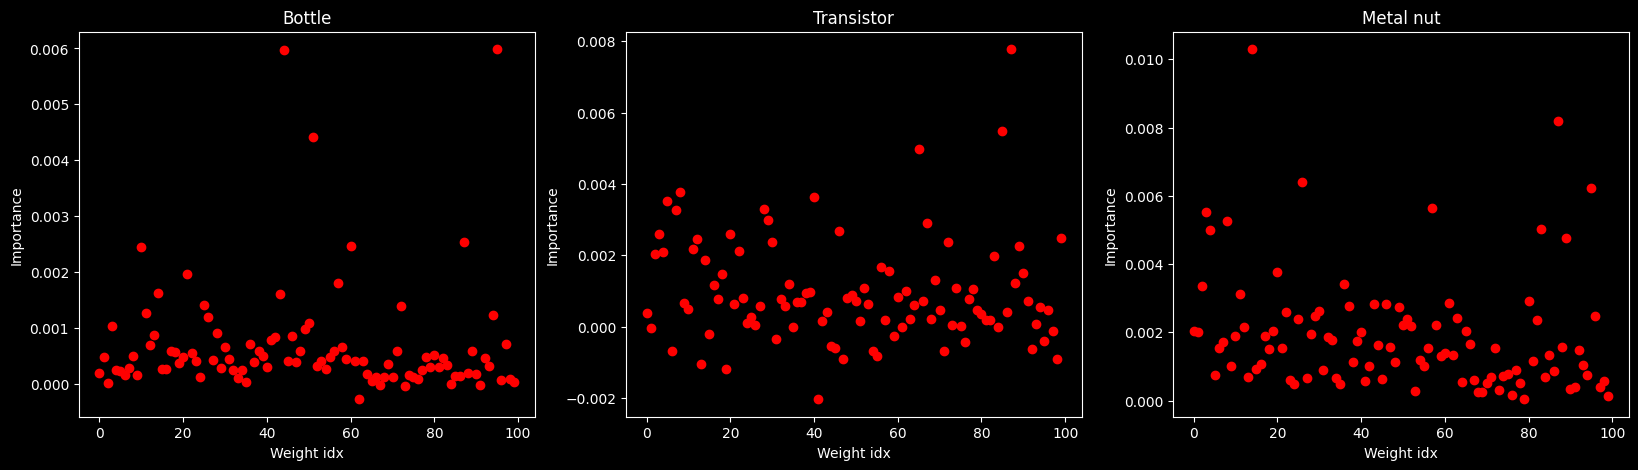

In [ ]:
#Task 1.2 continuation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(results['bottle'], 'ro')
ax2.plot(results['transistor'], 'ro')
ax3.plot(results['metal_nut'], 'ro')
ax1.set_xlabel('Weight idx')
ax1.set_ylabel('Importance')
ax1.set_title('Bottle')
ax2.set_xlabel('Weight idx')
ax2.set_ylabel('Importance')
ax2.set_title('Transistor')
ax3.set_xlabel('Weight idx')
ax3.set_ylabel('Importance')
ax3.set_title('Metal nut')
fig.show()

In [60]:
# Task 1.3
best_results = []
worst_results = []
first_results = []
for c in CLASS_NAMES:
    train_dataset = MVTecDataset(DATA_PATH, class_name=c, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    test_dataloader = dataloaders[c]["test_dataloader"]

    best_features = np.sort(np.argsort(np.array(results[c]))[-10:][::-1])
    worst_features = np.sort(np.argsort(np.array(results[c]))[:10])
    first_10_features = range(10)
    padim_best = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=torch.tensor(best_features),
        save_path=SAVE_PATH,
        plot_metrics=False,)
    padim_worst = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=torch.tensor(worst_features),
        save_path=SAVE_PATH,
        plot_metrics=False,)
    padim_first = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=torch.tensor(first_10_features),
        save_path=SAVE_PATH,
        plot_metrics=False,)
    padim_best.train(train_dataloader)
    padim_worst.train(train_dataloader)
    padim_first.train(train_dataloader)
    best_results.append(padim_best.test(test_dataloader))
    worst_results.append(padim_worst.test(test_dataloader))
    first_results.append(padim_first.test(test_dataloader))


Feature extraction (test): 100%|██████████| 57/57 [00:03<00:00, 14.98it/s]


In [61]:
print('Classes: Bottle, Transistor, Metal Nut')
print('Results for models trained on the best features: ', best_results)
print('Results for models trained on the worst features: ', worst_results)
print('Results for models trained on the first 10 features: ', first_results)
print('mean best: ', np.mean(np.array(best_results)) )
print('mean worst: ', np.mean(np.array(worst_results)) )
print('mean first: ', np.mean(np.array(first_results)) )

Classes: Bottle, Transistor, Metal Nut
Results for models trained on the best features:  [0.9769819978827435, 0.9550489810132194, 0.9205818388543504]
Results for models trained on the worst features:  [0.9559114151433918, 0.941418417312982, 0.8916951822919511]
Results for models trained on the first 10 features:  [0.9696239539684349, 0.9561341961206908, 0.9384783352907186]
mean best:  0.9508709392501045
mean worst:  0.9296750049161083
mean first:  0.9547454951266148


Task 1.3: The authors claim seems to be true. Difference between mean results across classes between models trained on worst and best features is very small. Difrence between models trained on best features and 10 first features is even smaller. The fact that models trained on 10 first features in some cases outperformed models trained on 10 best features gives even more credibility to the claim that we could choose the features at random.

In [62]:
# Run at the end, but do not modify - we will use this to asses your output.
for c in CLASS_NAMES:
    s = pd.Series(results[c])
    print(s.sort_values(ascending=False)[:10].index.tolist())
    print(s.sort_values(ascending=True)[:10].index.tolist())

def get_sorted_indices(loader):
    loader.dataset.return_only_indices = True
    indices = sorted([x.item() for x in loader])
    loader.dataset.return_only_indices = False
    return indices

for c in CLASS_NAMES:
    print(get_sorted_indices(dataloaders[c]["val_dataloader"]))
    print(get_sorted_indices(dataloaders[c]["test_dataloader"]))
    for v in dataloaders[c]["train_dataloaders"]:
        print(get_sorted_indices(v))

[95, 44, 51, 87, 60, 10, 21, 57, 14, 43]
[62, 73, 67, 91, 84, 2, 99, 35, 65, 96]
[87, 85, 65, 8, 40, 5, 28, 7, 29, 67]
[41, 19, 13, 98, 47, 55, 54, 6, 71, 92]
[14, 87, 26, 95, 57, 3, 8, 83, 4, 89]
[79, 99, 76, 68, 69, 53, 73, 90, 97, 91]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82]
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81]
[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 37, 38, 40, 41, 43, 44, 46, 47, 49, 50, 52, 53, 55, 56, 58, 59, 61, 62, 64, 65, 67, 68, 70, 71, 73, 74, 76, 77, 79, 80, 82, 83, 85, 86, 88, 89, 91, 92, 94, 95, 97, 98, 100, 101, 103, 104, 106, 107, 109, 110, 112, 113, 115, 116, 118, 119, 121, 122, 124, 125, 127, 128, 130, 131, 133, 134, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 151, 152,

# Task 2. Improving PADIM with Online Covariance Estimation

This implementation of PADIM can be improved in numerous ways. In this exercise, you'll try to indicate its shortcomings and provide some means to mitigate them.

#### 2.1. PADIM's training complexity (15%)

- Identify the key operations contributing to the algorithm's training space complexity *in this implementation*. Don't focus on the backbone, as it is not the part of the algorithm (however, its output is).
- Shortly discuss the implications for scalability. You can support your claims by charts if needed.

*Hint: this doesn't need to be super formal analysis - it's about fiding the "worst" parts of this implementation. You can support your claims with a chart and brief description (e.g. "X dominates the complexity, as it's quadratic.")*

```Your answer to task 2.1 goes here```
The biggest contributor to the space complexity of this algorithm is the fact that we are calculating the covariance matrixes in an ofline manner. Because of that, we have to store all the network outputs in memory. That means that our space complexity is linearly dependent on the size of our training set. This could create problems for scalability because if our training set is large, we would not have enough memory to store it on one training device.

In [ ]:
# Your code goes here (if needed)

#### 2.2 Online mean and covariance (35%)
Implement a PyTorch version of [online covariance matrix estimation](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Online) in the training as an alternative to the current method in PADIM.
Calculate the mean in an online fashion as well.
Your implementation shall run on the selected `torch.device` (such as GPU).
No need to reimplement the testing routine to online in this exercise (although it'd be nice to have for Task 1), albeit small changes might be necessary (such as conversion from `torch.Tensor` to `np.ndarray`).

Passing criteria:
```python
torch.allclose(padim_online.mean, torch.Tensor(padim_offline.mean).to(DEVICE), atol=0.01)
torch.allclose(padim_online.cov, torch.Tensor(padim_offline.cov).to(DEVICE), atol=0.01)
```


In [ ]:
class PADIMWithOnlineCovariance(PADIM):

    ### TODO: Your code goes here
    def __init__(
            self,
            backbone: str,
            device: torch.device,
            save_path: Path,
            backbone_features_idx: List[int],
            class_names=...,
            plot_metrics=False,
            ) -> None:
        super().__init__(backbone, device, save_path, backbone_features_idx, class_names, plot_metrics)

    def train(self, train_dataloader: DataLoader, C: int, H: int, W: int):
        """C, H, W come from the size of embeddings: [B, C, H, W]"""
        #self.train_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}

        mean = np.zeros((C, H * W))
        cov = np.zeros((C, C, H * W))
        n = 0

        for x, _, _ in tqdm(train_dataloader, desc='Feature extraction (train)'):
            n = n + 1
            self.train_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3'], list(self.outputs.keys())
            for k, v in self.outputs.items():
                #print('k.shape = ', k, ' v.shape = ', v.shape)
                self.train_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}

            embedding_vectors = concatenate_embeddings_from_all_layers(
                {k: torch.cat(v, 0) for k, v in self.train_outputs.items()})
            embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

            embedding = embedding_vectors_subset[0].view(C, H * W).numpy()

            mean = mean + (embedding - mean)/n

            for j in range(H*W):
                v = np.expand_dims(embedding[:, j], axis = 0)
                if n > 1:
                    cov[:, :, j] =(n-1)* (cov[:, :, j])/n +  ((v - mean[:, j].copy()).T @ (v - mean[:, j].copy()) )/(n-1)

            del(self.train_outputs)

        cov = cov + 0.01 * np.expand_dims(np.identity(C), axis = 2)

        self.mean, self.cov = torch.tensor(mean).to(DEVICE).float(), torch.tensor(cov).to(DEVICE).float()
    ### END OF YOUR CODE

In [ ]:
# do not modify
seed_all(SEED)
class_name = 'bottle'
BATCH_SIZE = 1
RESIZE = 256 * 1
CROP_SIZE = 224 * 1
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 30
MAX_NUMBER_OF_BACKBONE_FEATURES = 448
# DEVICE="cpu"

indices = sample_idx(NUMBER_OF_BACKBONE_FEATURES, MAX_NUMBER_OF_BACKBONE_FEATURES).to(DEVICE)

run_timestamp = time.time()
SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)


padim_offline = PADIM(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)
padim_offline.train(train_dataloader)

padim_online = PADIMWithOnlineCovariance(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)
padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))

torch.allclose(padim_online.mean, torch.Tensor(padim_offline.mean).to(DEVICE), atol=0.01) and torch.allclose(padim_online.cov, torch.Tensor(padim_offline.cov).to(DEVICE), atol=0.01)

Feature extraction (train): 100%|██████████| 209/209 [01:11<00:00,  2.91it/s]


True

#### 2.3 Performance experiments (10%)
If you completed task 2.2, design experiments to empirically compare `space/memory` performance of PADIM training with both traditional and online covariance matrix estimation. Write short conclusions.

#### 2.4 Bonus task (optional)
You can also add similar experiments with conclusions with regard to the `time` complexity. This task is optional, but if you'll loose points elsewhere, this can help you to make up for some of them.

In [ ]:
!pip install memory-profiler --quiet
%load_ext memory_profiler

In [ ]:
# Your code goes here
padim_ofline_for_memory_training = PADIM(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)
padim_online_for_memory_training = PADIMWithOnlineCovariance(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)

%memit padim_ofline_for_memory_training.train(train_dataloader)
%memit padim_online_for_memory_training.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))

Covariance estimation: 100%|██████████| 3136/3136 [00:01<00:00, 2528.71it/s]


peak memory: 7302.47 MiB, increment: 3361.27 MiB


Feature extraction (train): 100%|██████████| 209/209 [01:08<00:00,  3.05it/s]

peak memory: 3942.48 MiB, increment: 0.10 MiB


```Your conclusions go here```
Based on this result, it is clear that online PADIM has lower memory requirements.

Task 2.4

In [ ]:
import time

class_names = ['bottle', 'transistor', 'metal_nut']
ofline_times = []
online_times = []
for class_name in class_names:
    train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
    val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)


    padim_offline = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=indices,
        save_path=SAVE_PATH,
        plot_metrics=True,
    )

    start_time = time.time()
    padim_offline.train(train_dataloader)
    end_time = time.time()
    ofline_times.append(end_time - start_time)

    padim_online = PADIMWithOnlineCovariance(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=indices,
        save_path=SAVE_PATH,
        plot_metrics=True,
    )
    start_time = time.time()
    padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))
    end_time = time.time()
    online_times.append(end_time - start_time)

print(' ')
print('Mean training time of OFLINE PADIM across clases is ', np.mean(np.array(ofline_times)))
print('Mean training time of ONLINE PADIM across clases is ', np.mean(np.array(online_times)))

Feature extraction (train): 100%|██████████| 220/220 [01:14<00:00,  2.97it/s]

 
Mean time of OFLINE PADIM across clases is  52.500293016433716
Mean time of ONLINE PADIM across clases is  74.36910740534465


We can see that ofline PADIM is significantly faster than this implementation of online PADIM.
